## Logit Lens: описание подхода

Разберем его на примере классических генеративных языковых моделей. У них к выходному слою применяется функция активации, чтобы преобразовать выходы в вероятности.

**Logit Lens** - это метод, основанный на том, что мы пробуем применить эту же функцию активации к более ранним слоям, чтобы иметь возможность как-то интерпретировать работу модели.

Работу нейросетей обычно достаточно сложно интерпретировать. В контексте трансформеров - обычно изучают то, на что направлено внимание сетки (то есть изучают слои attention).

Отличие Logit Lens (будем называть LL) от классического подхода: традиционный метод фокусируется на том, как модель обновляет свою "веру" на каждом шаге, а LL делает акцент именно на том, во что модель верит.

Важно помнить, что результаты LL - это лишь частичная интерпретация

### Этапы "уверенности" модели

Поймем, что нам дает LL. На самом деле, в глубокой сети уверенность в ответе обычно появляется задолго до последнего слоя, просто модель уточняет некоторые детали. В целом, модель проходит шаги от полной неуверенности в ответе до сначала некоторых догадок, а потом уже уверенных предположений. Разумеется, в каких-то случаях некоторые из этих этапов не встречаются.

### Интересные выводы про LL

В исследованиях заметили, что начальные слои хранят что-то вроде "бессмыслицы" (тотальная неуверенность). В том смысле, что входные данные мгновенно преобразуются в сложное представление, которое, однако, понятно для модели, и постепенно преобразуется в ответ. То есть сетка ни в каком виде не пытается хотя бы примерно хранить input-ы, она мгновенно их изменяет.

## Применение

Возьмем модель Qwen2-VL, нам в принципе не нужна большая модель, так что можно взять с квантизацией весов

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Сначала просто тестируем

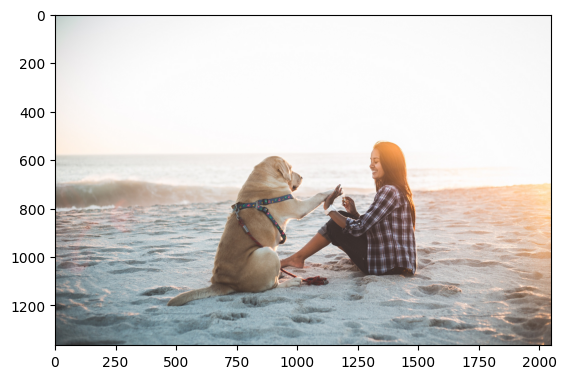

In [ ]:
from matplotlib import pyplot as plt

# Вот так выглядит картинка, которую модель берет отсюда: https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg
img = plt.imread('demo.jpeg')
plt.imshow(img)
plt.show()

Код со странички модели на HF

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct-GPTQ-Int4", torch_dtype="auto", device_map="auto"
)


min_pixels = 256*28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct-GPTQ-Int4", min_pixels=min_pixels, max_pixels=max_pixels)


messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


CUDA extension not installed.
CUDA extension not installed.
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
C:\Users\ptarh\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:5019: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
C:\Users\ptarh\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\qwen2_vl\modeling_qwen2_vl.py:404: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = F.scaled_dot_product_attention(q, k, v, attention_mask, dropout_p=0.0)


['The image depicts a woman sitting on a sandy beach with her dog. The dog is sitting on the sand, facing the woman, and is wearing a colorful harness. The woman is smiling and giving the dog a high-five. The background shows the ocean with gentle waves, and the sky is clear with a soft light, suggesting it might be either sunrise or sunset. The overall scene is serene and joyful, capturing a moment of connection between the woman and her dog.']


Поймем структуру нашей модели. Глобально у нее есть структуры:
* visual
* model

Visual состоит из:
* patch_embedding (свертка)
* blocks (блоки Visual Attention)
* merger (layer_norm и линейные слои)

Model:
* embed_layer
* self-attention
* и далее разные линейные и нормировочные слои

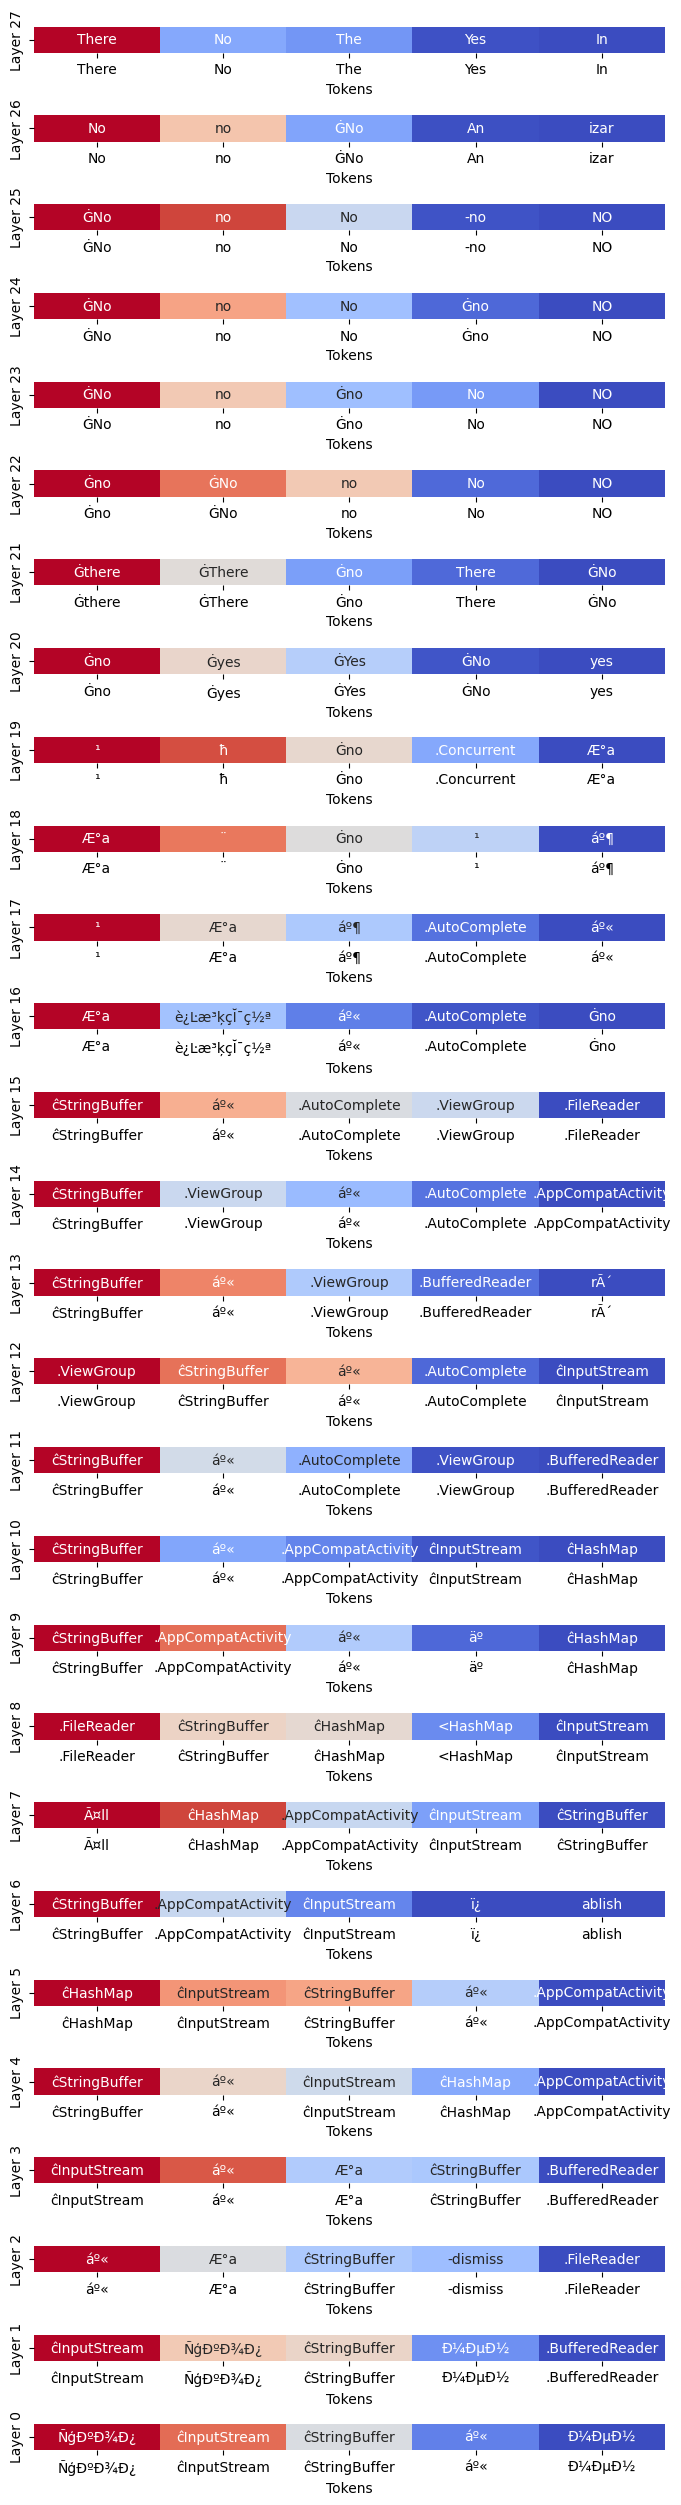

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

def logit_lens_visualization(model, processor, inputs, top_k=5):
    """
    Применяет Logit Lens к чётным слоям декодера и визуализирует top-k вероятностей токенов в виде heatmap.
    Вывод: для каждого слоя (в обратном порядке, от высших к низшим) отображается одна строка:
           layer_X | top_1_token, top_2_token, ..., top_k_token.
    """
    logits_by_layer = {}

    def hook_fn(layer_id):
        def hook(module, input, output):
            with torch.no_grad():
                hidden_states = output[0] if isinstance(output, (list, tuple)) else output
                logits = model.lm_head(hidden_states)
                probs = torch.nn.functional.softmax(logits, dim=-1)
                top_probs, top_indices = probs.topk(top_k, dim=-1)
                if top_probs.ndim == 3:
                    top_probs = top_probs[:, -1, :]
                    top_indices = top_indices[:, -1, :]
                logits_by_layer[layer_id] = (top_probs.cpu().numpy(), top_indices.cpu().numpy())
        return hook

    hooks = []
    for i, layer in enumerate(model.model.layers):
        # if i % 2 == 0:      - слоев не так много (28), я решил попробовать визуализировать по всем
        #     hooks.append(layer.register_forward_hook(hook_fn(i)))
        hooks.append(layer.register_forward_hook(hook_fn(i)))

    with torch.no_grad():
        model.generate(**inputs, max_new_tokens=1)

    for hook in hooks:
        hook.remove()

    sorted_layer_ids = sorted(logits_by_layer.keys(), reverse=True)
    n_layers = len(sorted_layer_ids)

    fig, axes = plt.subplots(n_layers, 1, figsize=(10, n_layers * 2))
    if n_layers == 1:
        axes = [axes]

    # словарь токена: id -> слово
    vocab = processor.tokenizer.get_vocab()
    id_to_word = {v: k for k, v in vocab.items()}

    for ax, layer_id in zip(axes, sorted_layer_ids):
        top_probs, top_indices = logits_by_layer[layer_id]  # top_probs.shape == (1, top_k)
        tokens = [id_to_word.get(int(idx), f"<{idx}>") for idx in top_indices[0]]
        annot = [tokens]
        sns.heatmap(
            top_probs,
            annot=annot,
            fmt="",
            cmap="coolwarm",
            xticklabels=tokens,
            yticklabels=[f"Layer {layer_id}"],
            cbar=False,
            ax=ax
        )
        ax.set_xlabel("Tokens")
        ax.set_ylabel("")
    plt.gcf().set_size_inches(7, 25)
    plt.tight_layout()
    plt.show()

# тестовый пример

messages = [
    {"role": "user", "content": [
        {"type": "image", "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"},
        {"type": "text", "text": "Is there a car on the image?"},
    ]}
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to("cuda")

logit_lens_visualization(model, processor, inputs)


Здесь пример довольно простой, на картинке изображены собака и девушка на фоне моря. Очевидно, автомобиля там нет. Если рассматривать нумерацию слоев с 0, то модель хорошо догадывается уже с 16 слоя (потому что 'no' попадает уже в топ-5 по вероятности). И в дальнейшем no стабильно превалирует над yes. Изменение происходит только в последнем слое, потому что модель генерирует ответ с точки зрения корректной грамматики (см. результат ниже)

Comment: есть предположение, что Ġ - это какой-то некорректно распаршенный служебный токен, поэтому будем опускать при чтении результатов и интерпретации.

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Is there a car on the image?"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['There is no car visible in the image.']


Легко заметить, что модель легко справилась с этим заданием

Сделаем более сложную задачу. Я взял mixup-картинку, выглядит она так:

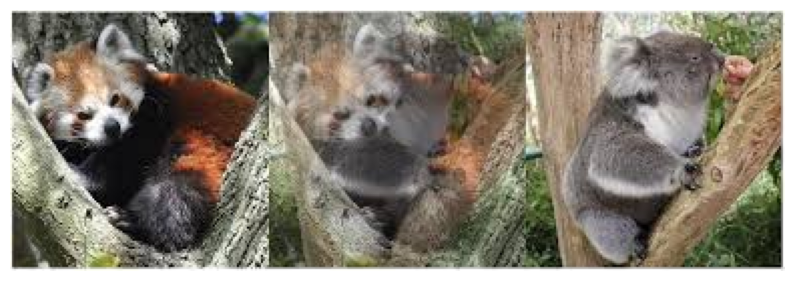

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Ссылка на картинку
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTmbivHlTp_2JfrO1RK5yd5cT0cglvykgPAhQ&s"

response = requests.get(url)
image = Image.open(BytesIO(response.content))
plt.figure(figsize = (10, 30))
plt.imshow(image)
plt.axis("off")  # уберем оси
plt.show()


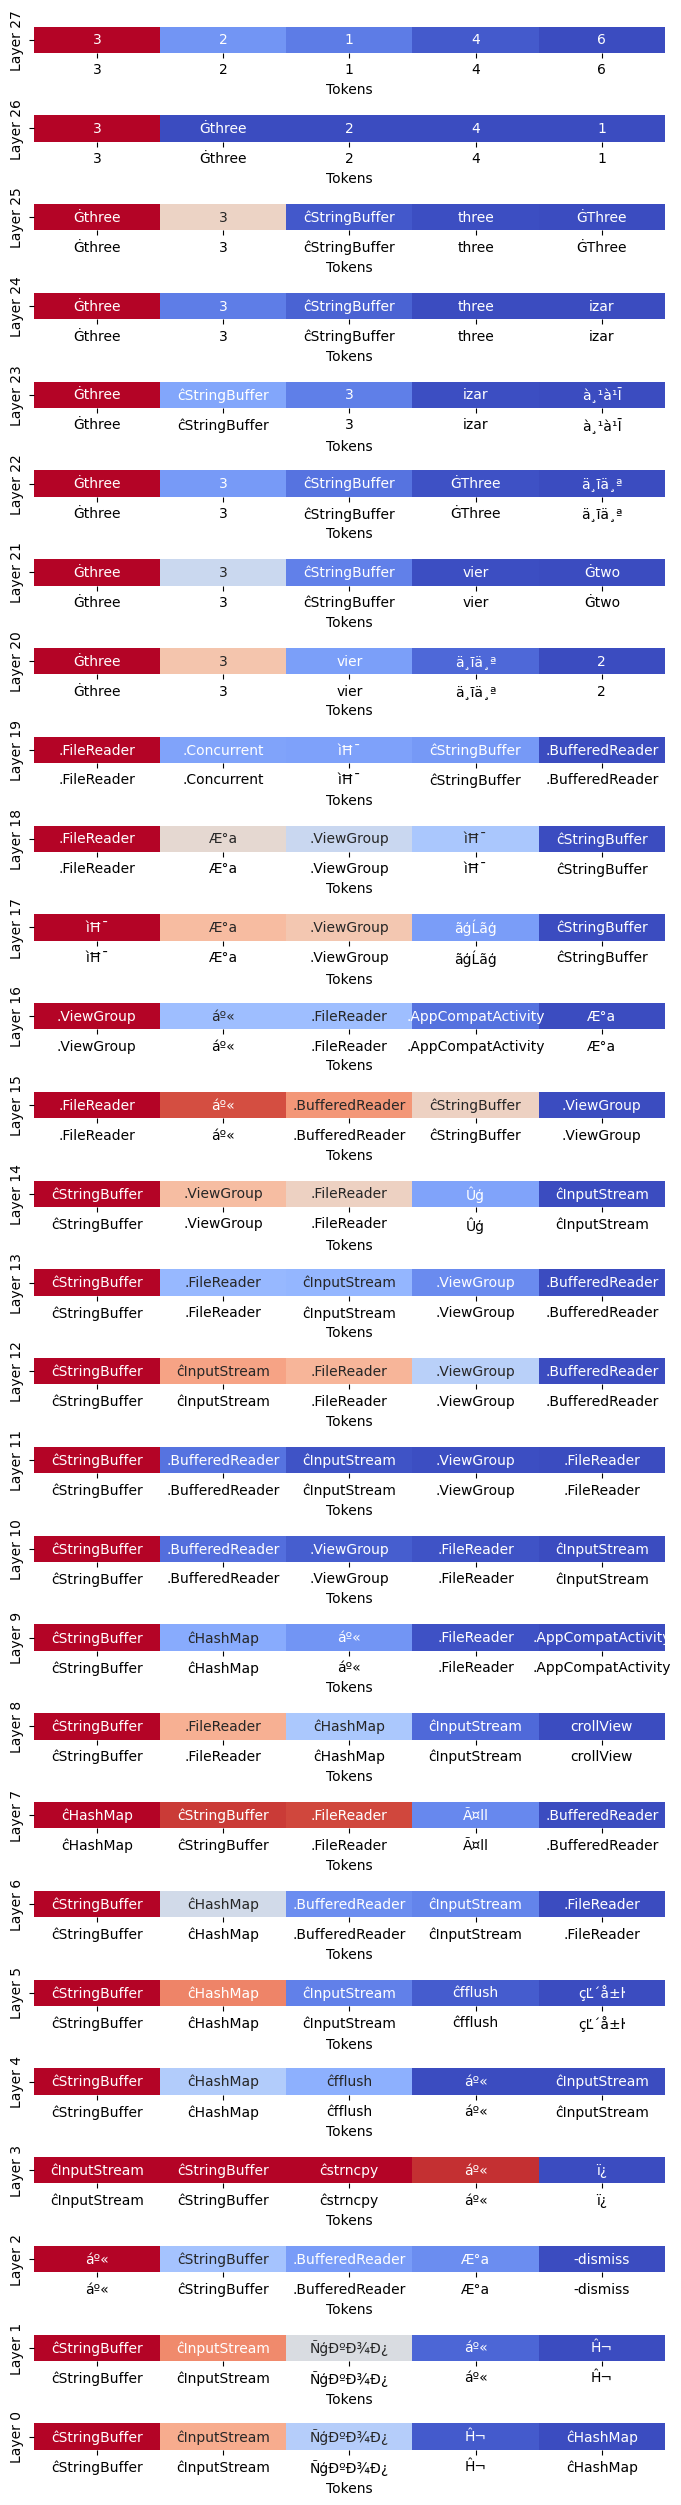

In [ ]:
messages = [
    {"role": "user", "content": [
        {"type": "image", "image": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTmbivHlTp_2JfrO1RK5yd5cT0cglvykgPAhQ&s"},
        {"type": "text", "text": "What is the number of koalas in this picture? Write only the value"},
    ]}
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to("cuda")

logit_lens_visualization(model, processor, inputs)

Comment: в переводе с немецкого vier - четыре. Это все еще далеко от правды, но любопытно наблюдать, как модель обдумывает ответ на разных языках

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTmbivHlTp_2JfrO1RK5yd5cT0cglvykgPAhQ&s",
            },
            {"type": "text", "text": "What is the number of koalas in this picture?"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['There are three koalas in the picture.']


Итак, здесь уже модель ошиблась сильно. Она обратила внимание только на правую часть картинки, хотя, очевидно, красная панда выглядит совсем не как коала. Причем она абсолютно уверена в ответе = 3 уже начиная с 20 слоя, и в результате модель пишет именно это число. Кстати, предположение, что модель не знает, как выглядит красная панда, является ложным. Если ее спросить про эту же картинку, есть ли на ней красная панда, она совершенно уверено дает положительный ответ.

Еще пример, чтобы запутать модель

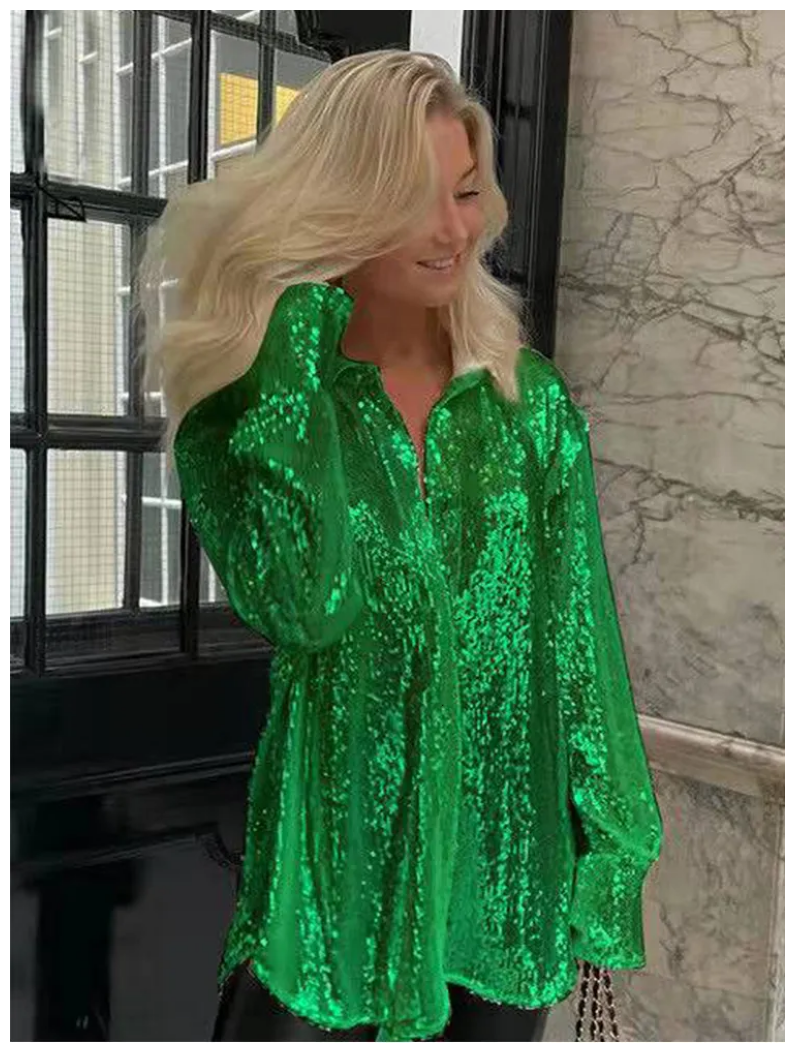

In [ ]:
import requests
url = "https://img4.dhresource.com/webp/m/0x0/f3/albu/km/m/03/845621b0-0ae7-4e5d-90bd-bc0e6c3a6b4b.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content))
plt.figure(figsize = (10, 30))
plt.imshow(image)
plt.axis("off")  # уберем оси
plt.show()

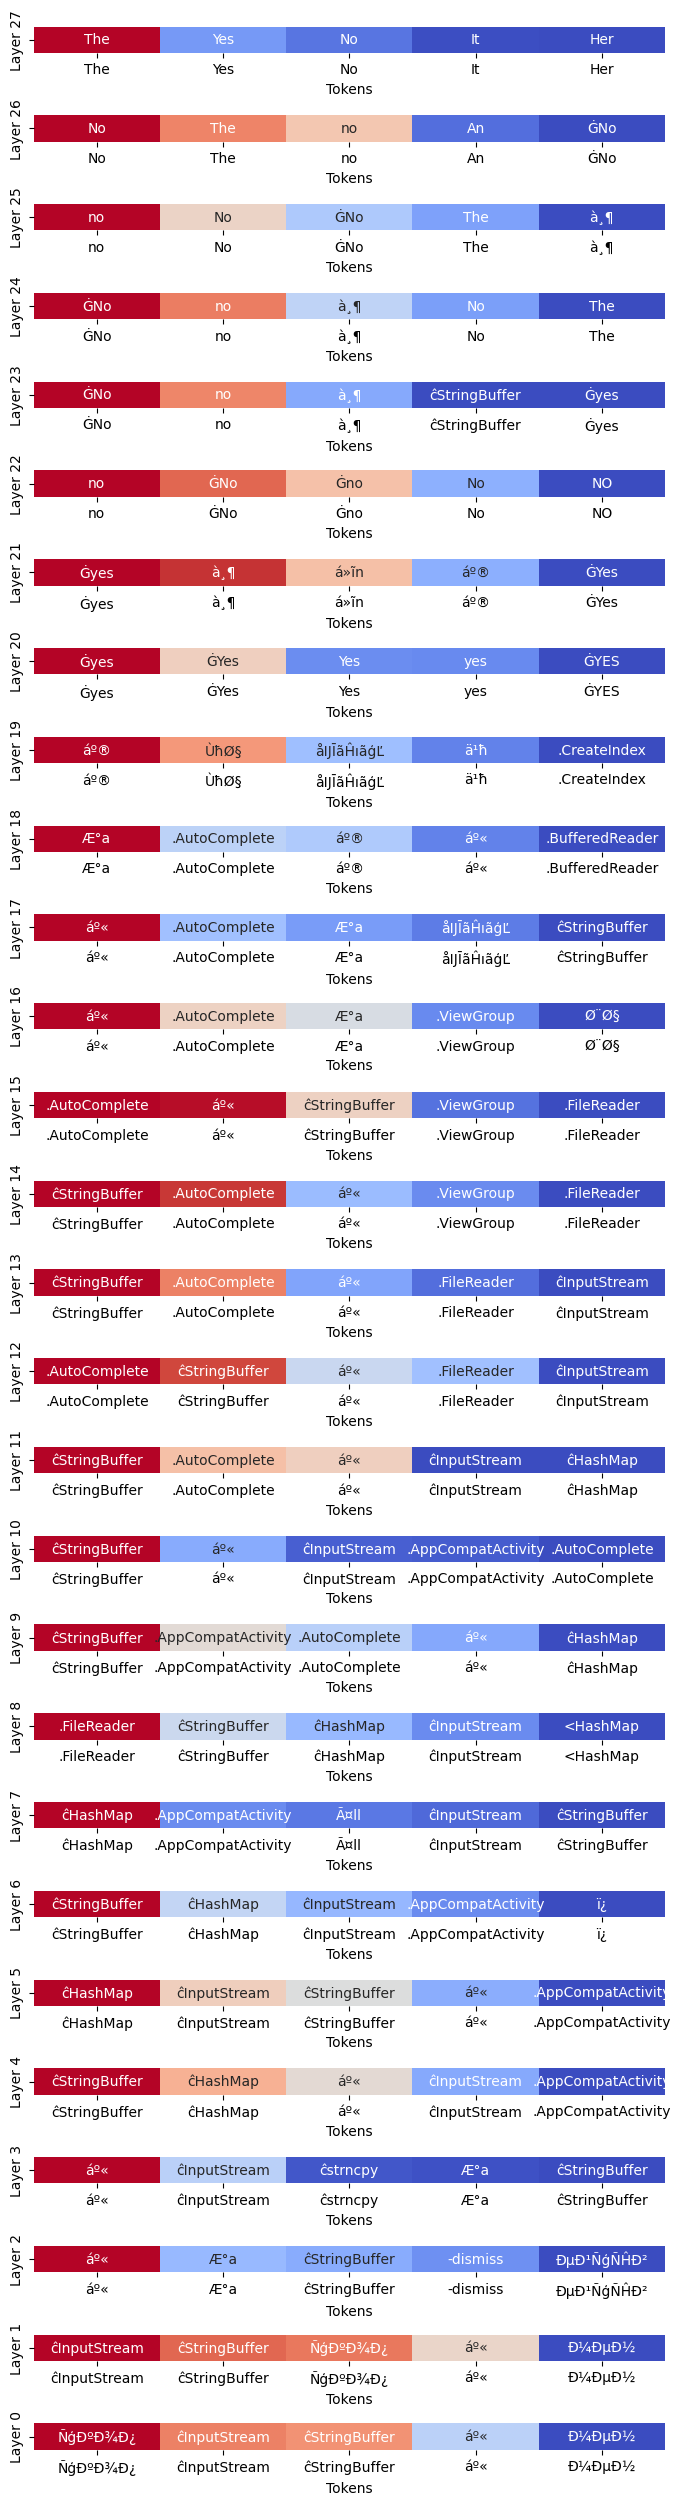

In [ ]:
messages = [
    {"role": "user", "content": [
        {"type": "image", "image": "https://img4.dhresource.com/webp/m/0x0/f3/albu/km/m/03/845621b0-0ae7-4e5d-90bd-bc0e6c3a6b4b.jpg"},
        {"type": "text", "text": "Is the color of her hair green?"},
    ]}
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to("cuda")

logit_lens_visualization(model, processor, inputs)

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://img4.dhresource.com/webp/m/0x0/f3/albu/km/m/03/845621b0-0ae7-4e5d-90bd-bc0e6c3a6b4b.jpg",
            },
            {"type": "text", "text": "Is the color of her hair green?"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The color of her hair is not green. It appears to be a blonde color with waves.']


Этот пример еще более интересный. Модель колеблется между ответами. Вначале она дает ответ yes, затем исправляется, но в финальном слое ответ yes снова имеет большую вероятность, чем ответ no.

В целом, можно сделать такие выводы:
* ответ модели начинает зарождаться в среднем на 18-20 слоях
* зачастую слои 24-26 совпадают, но последний слой обычно очень резко меняет распределение - в угоду грамматике
* модель может обнаруживать правильный ответ на более ранних слоях (21-22), но далее начинает сомневаться и менять ответы

## Плюсы и минусы метода LL

Плюсы:
* показывает, в какой момент модель начинает формировать ответ
* прост в реализации, понятен

Минусы:
* в действительности не всегда факт, что колебания модели - это плохо (пример: вдруг модель размышляет "от противного")
* плохо позволяет понимать причины неверных ответов, которым модель дает высокую вероятность еще с ранних этапов

Про последнее - есть статья про "галлюцинации" модели, про которую я напишу ниже

Предложения: наверно, было бы хорошей идеей, например, посмотреть на каких-то датасетах статистику о том, как много слоев подряд "мыслят" одинаково. Еще интересно смотреть на датасеты классификации с 2 аспектов: задавать вопрос про наличие класса (например: "Есть ли на картинке коала/машина" и т.д.), или просто спрашивать про объект, находящийся на картинке. Первое поможет подсветить слабые стороны vision encoder, а второе - покажет, насколько хорошо декодер обрабатывает представления картинок.

Я выбрал такие статьи:

1) https://aclanthology.org/2024.emnlp-main.387.pdf
2) https://arxiv.org/html/2411.19187v1
3) как продолжение предыдущей: https://arxiv.org/html/2411.19187v1#S5



Первая статья выступает за поддержку и использование этого подхода. Авторы брали модели LLAVA-NeXT и InstructBLIP Они изучают домен-специфические нейроны (отвечающие за какие-то конкретные домены). Этих нейронов менее 1% от общего числа, но их отключение снижает accuracy на 10%. Но обычно модели их используют не очень активно.

Таким образом, авторы используют LL как инструмент для проверки своих гипотез, но анализируют на более детальном уровне (не просто по слоям).

Вероятно, такой подход было бы интересно применить для qwen2-vl, потому что тогда можно будет получить более подробный анализ работы модели.

Вторая статья рассматривает галлюцинации моделей - когда модель уверрено выдает неверный ответ. Испольховался датасет HQH. У LL здесь обнаруживаются существенные ограничения

Авторы нашли у LL такие минусы:
* LL проверяет только соответствие токенов, но не учитывает контекст (как раз таки тот случай, о котором я писал - вдруг модель рассуждает "от противного")
* метод малоэффективен в задачах OCR, поиском атрибутов объектов и пространственным отношениями/сравнением

Был предложен подход на основе контекстных эмбеддингов промежуточных слоев модели. Такой подход позволяет точнее детектировать галлюцинации и привязывать ответы модели к визуальным объектам. А еще он обеспечивает точную привязку ответов модели к объектам на изображении с помощью ограничивающих рамок и тем самым  упрощает задачу "атрибуции".



Из моделей: InternlmVL-7B и Qwen2VL-7B, так что это как раз про выбранную мною модель

Самое интересное - авторы делили картинки на сегменты и изучали галлюцинации
![](https://arxiv.org/html/2411.19187v1/extracted/6031972/images/fig2.png)

В целом, в ходе экспериментов я тоже нашел интересные выражения галлюцинаций в промежуточных слоях в задачах описания отдельных атрибутов на картинке и подсчета конкретных объектов

Так что фича из второй статьи является, наверно, наиболее существенным улучшением Logit Lens, которое позволило бы мне получше изучить природу наблюдаемых галлюцинаций